In [37]:
#importing all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix

In [38]:
%pip install instaloader


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import instaloader
import json

def fetch_account_info(username):
    loader = instaloader.Instaloader()

    try:
        profile = instaloader.Profile.from_username(loader.context, username)
        metadata = profile._metadata()

        account_info = {
            "username": metadata['username'],
            "followers": metadata['edge_followed_by']['count'],
            "following": metadata['edge_follow']['count'],
            "posts": metadata['edge_owner_to_timeline_media']['count'],
            "profile_picture": metadata['profile_pic_url'],
            "is_private": metadata['is_private'],
            "is_verified": metadata['is_verified'],
            "external URLS": metadata["external_url"],
            "full_name":metadata["full_name"],
            "business_category_name":metadata["business_category_name"],
            "desc_len":len(metadata["biography"]),
            "id":metadata["id"]

        }

        return account_info

    except instaloader.exceptions.ProfileNotExistsException:
        print(f"Profile {username} does not exist.")
        return None
    except instaloader.exceptions.InstaloaderException as e:
        print(f"An error occurred: {e}")
        return None

usernames = input("Enter Instagram usernames separated by commas: ").split(',')
usernames = [username.strip() for username in usernames]  # Strip any extra whitespace

# Fetch and display account information
results = {}

for username in usernames:
    account_info = fetch_account_info(username)
    if account_info:
        results = account_info
    else:
        results = "Could not fetch account information."


print(json.dumps(results,indent=4))


{
    "username": "lowebbvb44172989",
    "followers": 94,
    "following": 3735,
    "posts": 7,
    "profile_picture": "https://instagram.fdel3-5.fna.fbcdn.net/v/t51.2885-19/347783903_6159978217442291_7317239740707599890_n.jpg?stp=dst-jpg_e0_s150x150&_nc_ht=instagram.fdel3-5.fna.fbcdn.net&_nc_cat=111&_nc_ohc=litbsVrA32UQ7kNvgFpUAE0&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AYBsOC0-RzxKN7kG6IuGMoP_GQI1I99B4LcRMCug-b4DiQ&oe=666563FF&_nc_sid=8b3546",
    "is_private": false,
    "is_verified": false,
    "external URLS": null,
    "full_name": "Webb",
    "business_category_name": null,
    "desc_len": 0,
    "id": "57040995421"
}


In [40]:
if results["is_private"]=="null":
    results["is_private"]=0
else:
    results["is_private"]=1

In [41]:
if results["is_verified"]=="null":
    results["is_verified"]=0
else:
    results["is_verified"]=1

In [42]:
if results["external URLS"] is None:
    results["external URLS"]=0
else:
    results["external URLS"]=1

In [43]:

def count_numeric_chars(s):
    count = 0
    for char in s:
        if char.isdigit():
            count += 1
    return round(count/len(results["username"]),2)

# Example usage
input_string = results["username"]
num_user_count = count_numeric_chars(input_string)
print(f"Number of numeric characters: {num_user_count}")
len_username=len(results["full_name"].split())
print(len_username)

Number of numeric characters: 0.5
1


In [44]:

def count_num_chars(s):
    count = 0
    for char in s:
        if char.isdigit():
            count += 1
    return round(count/len(results["full_name"]),2)

# Example usage
input_string = results["full_name"]
num_full_count = count_num_chars(input_string)
print(f"Number of numeric characters: {num_full_count}")

Number of numeric characters: 0.0


In [45]:
if results["username"]==results["full_name"]:
    results["username"]=1
else:
    results["username"]=0

In [46]:
print(type(results["following"]))

<class 'int'>


In [47]:
print(type(results["following"]))

<class 'int'>


In [48]:
import cv2
import numpy as np
import urllib.request

def fetch_image_from_url(url):
    # Fetch the image from the URL and convert it to a numpy array
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def check_images_match(url1, url2):
    # Fetch images from URLs
    img1 = fetch_image_from_url(url1)
    img2 = fetch_image_from_url(url2)

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # Ensure descriptors are not None
    if des1 is None or des2 is None:
        return False

    # Initialize the BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # Match descriptors using knn
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Define a threshold for determining if images match
    good_matches_threshold = 5

    # Check if the number of good matches is above the threshold
    if len(good_matches) > good_matches_threshold:
        return True
    else:
        return False

# Example URLs
url1 = 'https://lh3.googleusercontent.com/u/0/drive-viewer/AKGpihZXovhBYY5hZe0aDjEgEsPNcGlSkGXjxHeSrHNtpXSXIlNdBZP479T8FGa7bodXRvv42S8YI-0Vqnf1H5oioDTM0_eu9OweUI4=w1850-h1088'
url2 = results["profile_picture"]

# Check if images match
if check_images_match(url1, url2):
    results["profile_picture"]=0
else:
    results["profile_picture"]=1

In [49]:
results

{'username': 0,
 'followers': 94,
 'following': 3735,
 'posts': 7,
 'profile_picture': 1,
 'is_private': 1,
 'is_verified': 1,
 'external URLS': 0,
 'full_name': 'Webb',
 'business_category_name': None,
 'desc_len': 0,
 'id': '57040995421'}

In [50]:
print(type(results["desc_len"]))

<class 'int'>


In [51]:
instagram_df_test = pd.read_csv('test.csv')
instagram_df_train = pd.read_csv('train.csv')

In [52]:
instagram_df_test.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [53]:
x_train = instagram_df_train.drop(columns = ['fake'])
x_test = instagram_df_test.drop(columns = ['fake'])
x_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.00,0,53,0,0,32,1000,955
1,1,0.00,2,0.00,0,44,0,0,286,2740,533
2,1,0.10,2,0.00,0,0,0,1,13,159,98
3,1,0.00,1,0.00,0,82,0,0,679,414,651
4,1,0.00,2,0.00,0,0,0,1,6,151,126
...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596
572,1,0.38,1,0.33,0,21,0,0,44,66,75
573,1,0.57,2,0.00,0,0,0,0,4,96,339
574,1,0.57,1,0.00,0,11,0,0,0,57,73


In [54]:
y_train = instagram_df_train['fake']
y_test = instagram_df_test['fake']
y_train

0      0
1      0
2      0
3      0
4      0
      ..
571    1
572    1
573    1
574    1
575    1
Name: fake, Length: 576, dtype: int64

In [55]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(x_train)
X_test = scaler_x.transform(x_test)

In [56]:
Y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [57]:
X_train.shape,X_test.shape

((576, 11), (120, 11))

In [58]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#Building the main model***

model = Sequential() 
model.add(Dense(50,input_dim = 11, activation = "relu")) #Initial Layer
model.add(Dropout(0.3))
model.add(Dense(150, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(25, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax")) #output layer

model.summary()

c:\Users\gauri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         3,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,077 (47.18 KB)

 Trainable params: 12,077 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [60]:
epochs_hist = model.fit(X_train, Y_train, epochs = 20, verbose = 1, validation_split = 0.1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5956 - loss: 0.6750 - val_accuracy: 0.8103 - val_loss: 0.5270
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8105 - loss: 0.4893 - val_accuracy: 0.8621 - val_loss: 0.3414
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8912 - loss: 0.3726 - val_accuracy: 0.8448 - val_loss: 0.2843
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8736 - loss: 0.3915 - val_accuracy: 0.8966 - val_loss: 0.2315
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9128 - loss: 0.2505 - val_accuracy: 0.9138 - val_loss: 0.2214
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9044 - loss: 0.2646 - val_accuracy: 0.9138 - val_loss: 0.2168
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8827 - loss: 0.3039 - val_accuracy: 0.9138 - val_loss: 0.2059
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9101 - loss: 0.2593 - val_accuracy: 0.9138 - val_loss

In [61]:
print(epochs_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


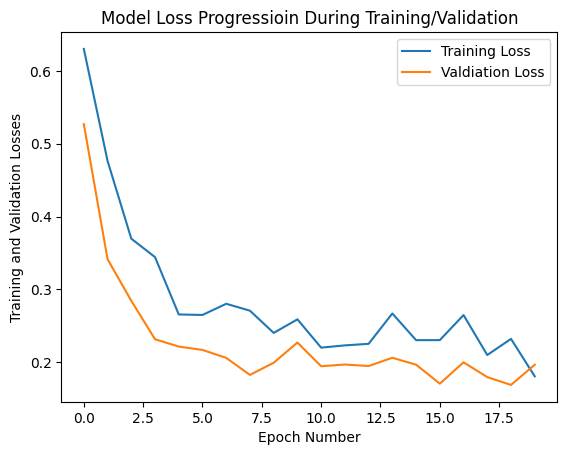

In [62]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progressioin During Training/Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Training and Validation Losses')
plt.legend(['Training Loss','Valdiation Loss'])


In [63]:
predicted = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [64]:
predicted_value = []
test = []
for i in predicted:
    predicted_value.append(np.argmax(i))

for i in Y_test:
    test.append(np.argmax(i))

In [65]:
print(results["profile_picture"],num_user_count,len_username,num_full_count,results["username"],results["desc_len"],results["external URLS"],results["is_private"],results["posts"],results["followers"],results["following"])

1 0.5 1 0.0 0 0 0 1 7 94 3735


In [66]:
INPUT=[results["profile_picture"],num_user_count,len_username,num_full_count,results["username"],results["desc_len"],results["external URLS"],results["is_private"],results["posts"],results["followers"],results["following"]]

In [67]:
print(INPUT)

[1, 0.5, 1, 0.0, 0, 0, 0, 1, 7, 94, 3735]


In [68]:
new_input = np.array([INPUT])

In [69]:
predicted_probabilities = model.predict(new_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [70]:
predicted_class = np.argmax(predicted_probabilities, axis=1)

In [71]:
print("Predicted class:", predicted_class[0])

Predicted class: 1
